Household energy consumption forecasting practice project

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for machine learning
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
# for deep learning
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [9]:
d = pd.read_csv('household_power_consumption.csv', header = 0, infer_datetime_format=True, parse_dates = ['datetime'], index_col = ['datetime'])

In [10]:
d.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


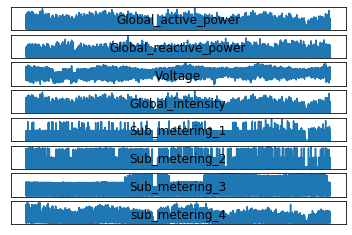

In [13]:
# line plot for each variable
plt.figure()
for i in range(len(d.columns)):
    # create sub plot
    plt.subplot(len(d.columns), 1, i+1)
    # generate variable names
    name = d.columns[i]
    # plot data
    plt.plot(d[name])
    # set title
    plt.title(name, y=0)
    # turn off ticks to remove clutter
    plt.yticks([])
    plt.xticks([])
plt.show()

Focussing on Global active power for any hidden patterns

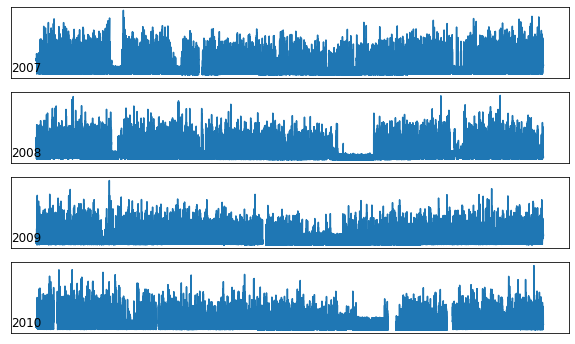

In [15]:
# plot active power for each year
years = ['2007', '2008', '2009', '2010']
plt.figure(figsize=(10,6))
for i in range(len(years)):
    # prepare subplot
    ax = plt.subplot(len(years), 1, i+1)
    # determine the year to plot
    year = years[i]
    # get all observations for the year
    result = d[str(year)]
    # plot the active power for the year
    plt.plot(result['Global_active_power'])
    # add a title to the subplot
    plt.title(str(year), y=0, loc='left')
    # turn off ticks to remove clutter
    plt.yticks([])
    plt.xticks([])
plt.show()

We can continue to zoom in on consumption and look at active power for each of the 12 months of 2007. This might help tease out gross structures across the months, such as daily
and weekly patterns

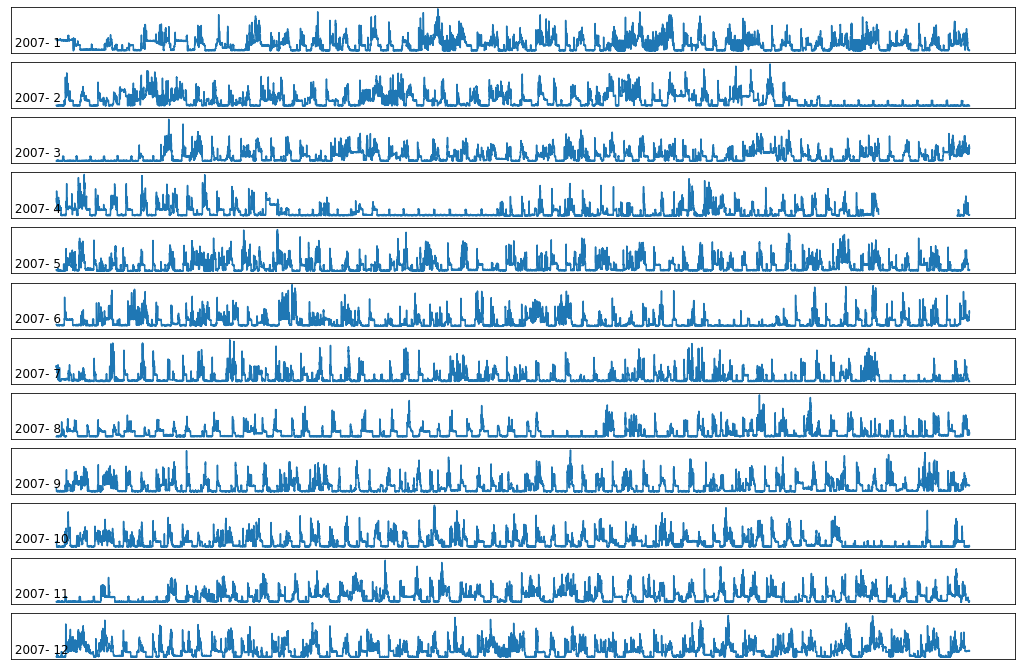

In [23]:
# plot active power for each year
months = [x for x in range(1, 13)]
plt.figure(figsize=(18,12))
for i in range(len(months)):
    # prepare subplot
    ax = plt.subplot(len(months), 1, i+1)
    # determine the month to plot
    month = ' 2007- ' + str(months[i])
    # get all observations for the month
    result = d[month]
    # plot the active power for the month
    plt.plot(result['Global_active_power'])
    # add a title to the subplot
    plt.title(month, y=0, loc='left')
    # turn off ticks to remove clutter
    plt.yticks([])
    plt.xticks([])
plt.show()

We can see the sign-wave of power consumption of the days within each month. This is good as we would expect some kind of daily pattern in power consumption. We can see that there are stretches of days with very minimal consumption, such as in August and in April. These may represent vacation periods where the home was unoccupied and where power consumption was minimal.

Lastly, let us also explore over daily level to get a clear picture of the patterns

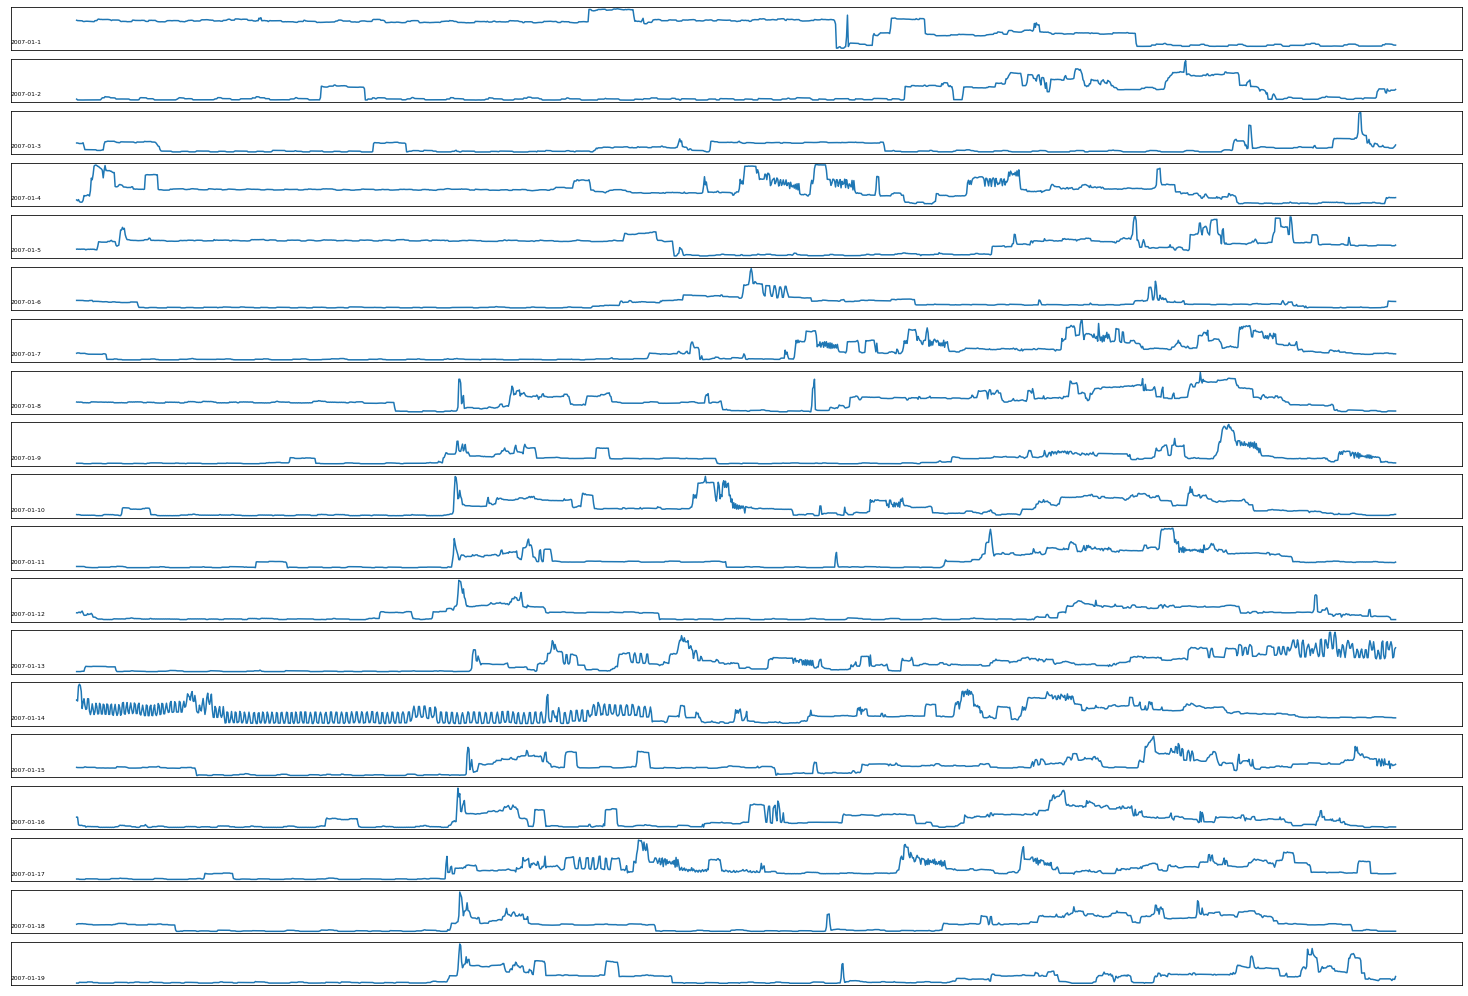

In [28]:
# plot active power for each year
days = [x for x in range(1, 20)]
plt.figure(figsize=(26,18))
for i in range(len(days)):
    # prepare subplot
    ax = plt.subplot(len(days), 1, i+1)
    # determine the day to plot
    day = '2007-01-' + str(days[i])
    # get all observations for the day
    result = d[day]
    # plot the active power for the day
    plt.plot(result['Global_active_power'])
    # add a title to the subplot
    plt.title(day, y=0, loc= 'left' , size=6)
    # turn off ticks to remove clutter
    plt.yticks([])
    plt.xticks([])
plt.show()

There is commonality across the days; for example, many days consumption starts early morning, around 6-7AM. Some days show a drop in consumption in the middle of
the day, which might make sense if most occupants are out of the house. We do see some strong overnight consumption on some days, that in a northern hemisphere January may match up
with a heating system being used. Time of year, specifically the season and the weather that it brings, will be an important factor in modeling this data, as would be expected


#### Distributions

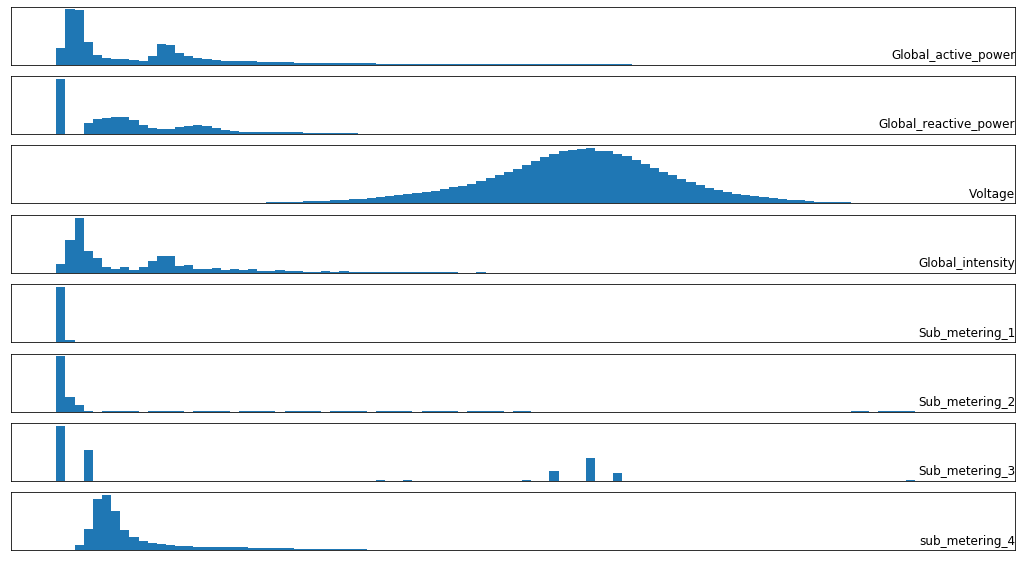

In [30]:
# histogram plot for each variable
plt.figure(figsize=(18,10))
for i in range(len(d.columns)):
    # create subplot
    plt.subplot(len(d.columns), 1, i+1)
    # get variable name
    name = d.columns[i]
    # create histogram
    d[name].hist(bins=100)
    # set title
    plt.title(name, y=0, loc='right')
    # turn off ticks to remove clutter
    plt.yticks([])
    plt.xticks([])
plt.show()

The distribution of active power appears to be bi-modal, meaning it looks like it has two mean groups of observations. We can investigate this further by looking at the distribution of active power consumption for the four full years of data.

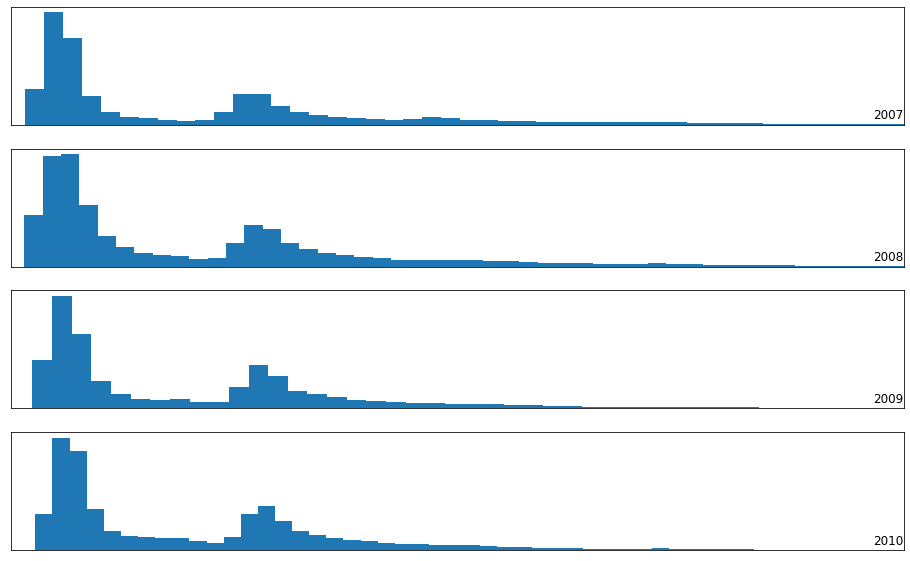

In [33]:
# plot active power for each year
years = [ '2007' , '2008' , '2009' , '2010']
plt.figure(figsize=(16,10))
for i in range(len(years)):
    # prepare subplot
    ax = plt.subplot(len(years), 1, i+1)
    # determine the year to plot
    year = years[i]
    # get all observations for the year
    result = d[str(year)]
    # plot the active power for the year
    result['Global_active_power'].hist(bins=100)
    # zoom in on the distribution
    ax.set_xlim(0, 5)
    # add a title to the subplot
    plt.title(str(year), y=0, loc='right')
    # turn off ticks to remove clutter
    plt.yticks([])
    plt.xticks([])
plt.show()

It is possible that the identified groups may vary over the seasons of the year. We can investigate this by looking at the distribution for active power for each month in a year.

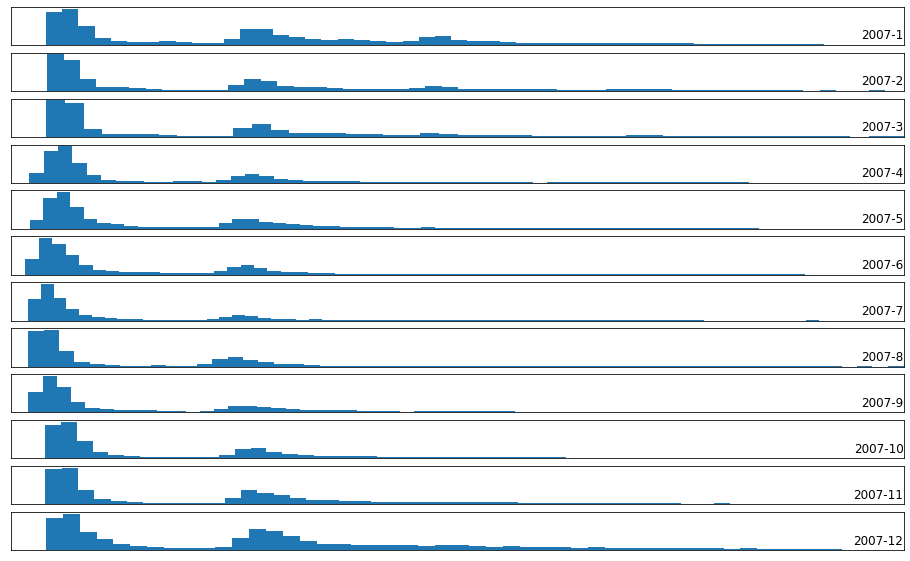

In [35]:
# plot active power for each year
months = [x for x in range(1, 13)]
plt.figure(figsize=(16,10))
for i in range(len(months)):
    # prepare subplot
    ax = plt.subplot(len(months), 1, i+1)
    # determine the month to plot
    month = '2007-' + str(months[i])
    # get all observations for the month
    result = d[month]
    # plot the active power for the month
    result['Global_active_power'].hist(bins=100)
    # zoom in on the distribution
    ax.set_xlim(0, 5)
    # add a title to the subplot
    plt.title(month, y=0, loc='right')
    # turn off ticks to remove clutter
    plt.yticks([])
    plt.xticks([])
plt.show()

### Naive forecasting

Given the historical seven days data, predict the next seven days.

Preparing data........

In [36]:
# resample minute data to total for each day for the power usage dataset
# resample data to daily
daily_groups = d.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

Error metric is RMSE as it is more punishing than MAE for forecasting errors. We take RMSE for each lead time from day 1 to day 7. A forecast will be comprised of seven values, one for each day of the week ahead. It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons:

     To comment on the skill at a specific lead time (e.g. +1 day vs +3 days)    
     To contrast models based on their skills at different lead times (e.g. models good at +1 day vs models good at days +5).

In [38]:
# evaluate one or more weekly forecasts against expected values
from math import sqrt
def evaluate_forecasts(actual, predicted):
    scores = []
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [58]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[0:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

In [65]:
d.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [73]:
d.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'sub_metering_4'],
      dtype='object')

In [75]:
# Columns that have nan:
dropping_list_all=[]
for j in range(0,7):
    if not d.iloc[:, j].notnull().all():
        dropping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
dropping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [78]:
# mean imputation
for j in range(0,7):        
    d.iloc[:,j]=d.iloc[:,j].fillna(d.iloc[:,j].mean())

In [79]:
d.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3               0
sub_metering_4           25979
dtype: int64

In [84]:
#lets drop last created column
d.drop(columns=['sub_metering_4'],inplace=True)

In [85]:
d.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Resampling over day

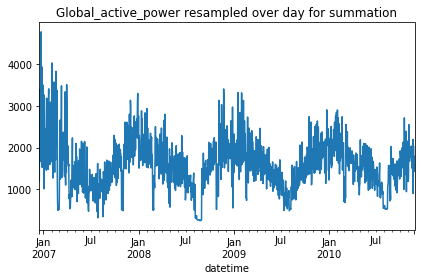

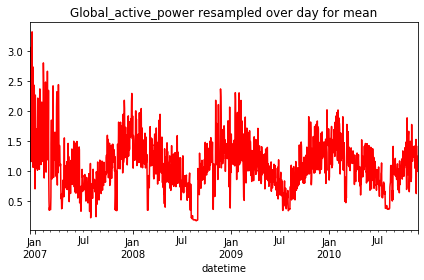

In [86]:
d.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for summation') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

d.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

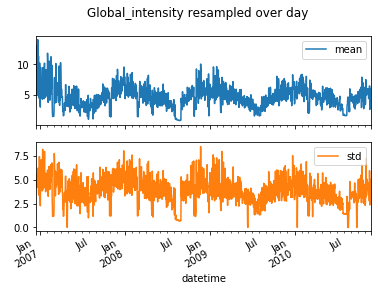

In [88]:
# mean and standard deviation of another column
r = d.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

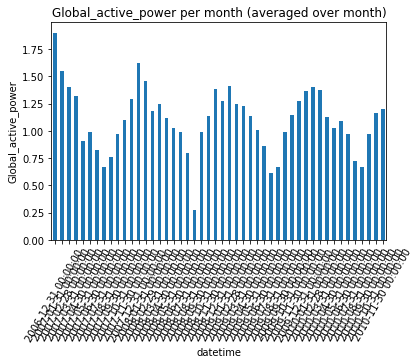

In [89]:
### Sum of 'Global_active_power' resampled over month
# Sum of 'Global_active_power' resampled over month
d['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

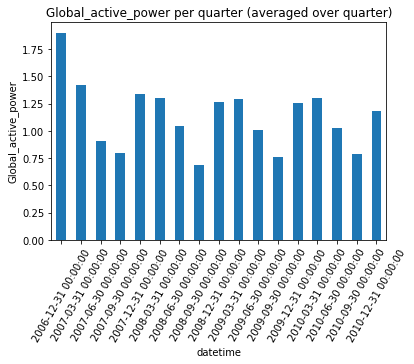

In [90]:
## Mean of 'Global_active_power' resampled over quarter
d['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

Resampling over larger interval will erode periodicity imbibed

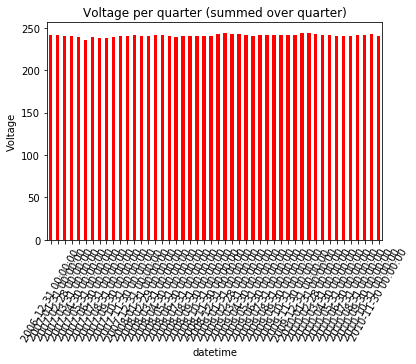

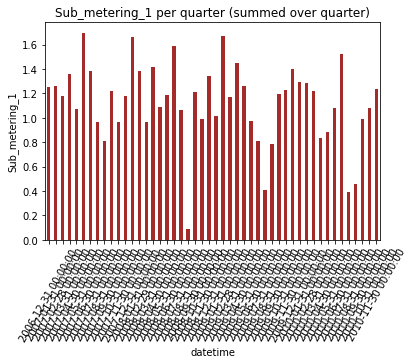

In [92]:
## mean of 'Voltage' resampled over month
d['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

d['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()

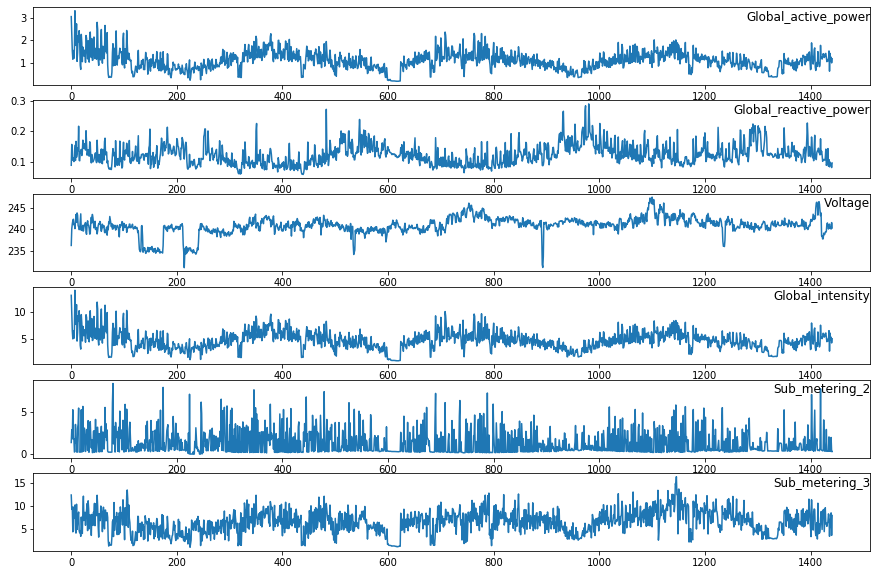

In [94]:
# Comparision of mean of different featuresresampled over day
# columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = d.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(d.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

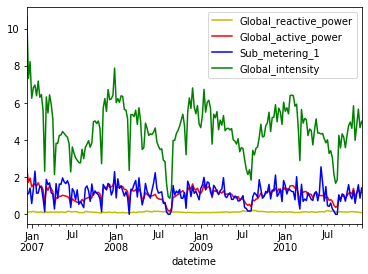

In [96]:
## resampling over week and computing mean
d.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
d.Global_active_power.resample('W').mean().plot(color='r', legend=True)
d.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
d.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

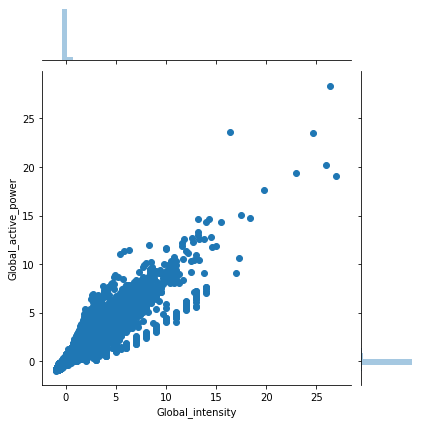

In [98]:
# correlations between 'Global_intensity', 'Global_active_power'
data_returns = d.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  
plt.show()

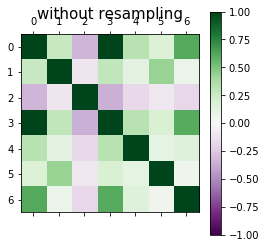

In [100]:
# correlation matrix
plt.matshow(d.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

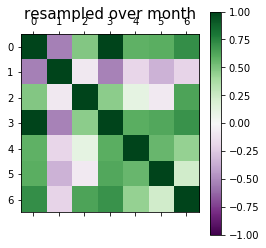

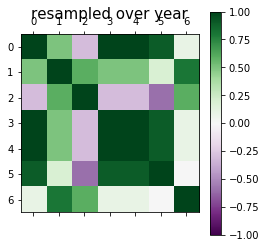

In [102]:
# correlation matrix of mean of features resampled over month
plt.matshow(d.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(d.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

#### Feature engineering and Machine learning
    Problem : To predict global_active_power at current time (t) given other lag features
    Model : Long Short Term Memory network (LSTM)

In [110]:
# ml
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
# dl
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [111]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [112]:
## resampling of data over hour
df_resample = d.resample('h').mean() 
df_resample.shape

(34589, 7)

In [113]:

# scalign in the range of (0,1) & to training resampled data (over hour)
values = df_resample.values 

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


7 input variables and 1 output variable ( global_active_power ) at current time resampled in hours.

Training on first year and testing on next three years of data for faster run.

In [114]:
# split into train and test sets
values = reframed.values
n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# Reshaped the input into 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


Model Architecture:

    1.LSTM with 100 neurons in the first visible layer
    2.20% dropout regularization
    3.1 neuron in the output layer for predicting Global_active_power
    4.Input shape will be 1 time step with 7 features
    5.Mean Absolute Error (MAE) is the metric and loss function is Adam version of stochastic gradient descent
    6.Model will be fit for 20 training epochs with a batch size of 70

Epoch 1/20
126/126 - 2s - loss: 0.0220 - val_loss: 0.0123
Epoch 2/20
126/126 - 2s - loss: 0.0130 - val_loss: 0.0110
Epoch 3/20
126/126 - 2s - loss: 0.0117 - val_loss: 0.0099
Epoch 4/20
126/126 - 1s - loss: 0.0110 - val_loss: 0.0095
Epoch 5/20
126/126 - 2s - loss: 0.0107 - val_loss: 0.0093
Epoch 6/20
126/126 - 2s - loss: 0.0106 - val_loss: 0.0093
Epoch 7/20
126/126 - 2s - loss: 0.0106 - val_loss: 0.0092
Epoch 8/20
126/126 - 2s - loss: 0.0106 - val_loss: 0.0092
Epoch 9/20
126/126 - 2s - loss: 0.0105 - val_loss: 0.0093
Epoch 10/20
126/126 - 2s - loss: 0.0105 - val_loss: 0.0092
Epoch 11/20
126/126 - 2s - loss: 0.0105 - val_loss: 0.0093
Epoch 12/20
126/126 - 2s - loss: 0.0104 - val_loss: 0.0094
Epoch 13/20
126/126 - 2s - loss: 0.0104 - val_loss: 0.0092
Epoch 14/20
126/126 - 2s - loss: 0.0104 - val_loss: 0.0092
Epoch 15/20
126/126 - 3s - loss: 0.0104 - val_loss: 0.0092
Epoch 16/20
126/126 - 2s - loss: 0.0104 - val_loss: 0.0092
Epoch 17/20
126/126 - 2s - loss: 0.0104 - val_loss: 0.0092
Epoch 

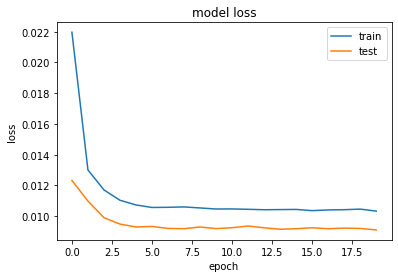

Test RMSE: 0.614


In [115]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Adjusting hyper parameters will improve the result

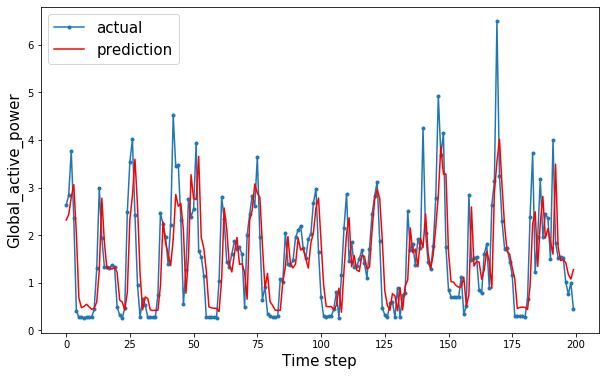

In [118]:
# every time step is an hour and 200 hours are used for comaparision 
plt.figure(figsize=(10,6))
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

Further improvements are:

    1. Adding a CNN model as there are correlations and good way to probe local structure of the data.
    2. Adding multiple drop-out layers
    3. Training without resampling on a GPU for faster computation and results